In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, UpSampling1D
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.cross_validation import KFold
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io

Using TensorFlow backend.
/Users/Nikos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Setting the random seeds
random.seed(1)
np.random.seed(1337)

In [3]:
def load_data(filepath):

# Description: This function is responsible for loading our data.
# Args in: filepath - the path of the .mat file containing the data
# Returns: inputs - the data, labels - the labels corresponding to the data, 
#            patients - the patients corresponding to the data

    mat = scipy.io.loadmat(filepath)
    inputs = mat['U0_new'][:]
    labels = mat['Y']
    patients = mat['patientID']

    labels = np.einsum('ij->ji', labels)
    labels = [label for sublist in labels for label in sublist]
    patients = np.einsum('ij->ji', patients)
    patients = [patient for sublist in patients for patient in sublist]

    return inputs, labels, patients

In [4]:
def get_non_frail(inputs, labels, patients):

#Description: This function allows us to access specifically the data corresponding to the patients
#that are labeled as being not frail.
#Args in & Returns are self-explanatory.
    
    first_pre_frail_index = labels.index(1)
    last_pre_frail_index = len(labels) - 1 - labels[::-1].index(1)
    
    inputs = np.asarray(list(inputs[:first_pre_frail_index]))
    labels = np.asarray(list(labels[:first_pre_frail_index]))
    patients = np.asarray(list(patients[:first_pre_frail_index]))
    
    assert(np.unique(labels) == [0])
    
    return inputs, labels, patients

def get_pre_frail(inputs, labels, patients):

# Description: Symmetric to the function above.
# Args in & Returns are self-explanatory.
    
    first_pre_frail_index = labels.index(1)
    last_pre_frail_index = len(labels) - 1 - labels[::-1].index(1)
    
    inputs = np.asarray(list(inputs[first_pre_frail_index:last_pre_frail_index+1]))
    labels = np.asarray(list(labels[first_pre_frail_index:last_pre_frail_index+1]))
    patients = np.asarray(list(patients[first_pre_frail_index:last_pre_frail_index+1]))
    
    assert(np.unique(labels) == [1])
    
    return inputs, labels, patients

def get_frail(inputs, labels, patients):
 
# Description: Symmetric to the function above.
# Args in & Returns are self-explanatory.
    
    first_pre_frail_index = labels.index(1)
    last_pre_frail_index = len(labels) - 1 - labels[::-1].index(1)
    
    inputs = np.asarray(list(inputs[last_pre_frail_index+1:]))
    labels = np.asarray(list(labels[last_pre_frail_index+1:]))
    patients = np.asarray(list(patients[last_pre_frail_index+1:]))
    
    assert(np.unique(labels) == [2])
    
    return inputs, labels, patients

In [5]:
def filter_duplicates(duplicates_list, inputs, targets, patients):

# Description: This function is responsible for filtering out
# some patients that are found to be present in more than one classes.
# Args in & Returns are self-explanatory.
    
    patients = list(patients)
    
    duplicate_indices = []
    for duplicate in duplicates_list:
        #patients = list(filter(lambda a: a != duplicate, patients))
        for i in range(len(patients)):
            if patients[i] == duplicate:
                duplicate_indices.append(i)
    
    duplicate_indices = set(duplicate_indices)
    all_indices = set([i for i in range(len(patients))])
    valid_indices = set(all_indices - duplicate_indices)
    inputs = [inputs[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    patients = [patients[i] for i in valid_indices]
    
    return inputs, targets, np.asarray(patients)

In [6]:
inputs, labels, patients = load_data('/Users/Nikos/Desktop/MyResearch/Zacharaki/PARAFACmissingvalues0_90/ReconstructedTensorAndFeatures90Missing_StrSGD.mat')

In [7]:
inputs, labels, patients = filter_duplicates([1002, 1104], inputs, labels, patients)
#print(inputs.shape, labels.shape, patients.shape)
non_frail_inputs, non_frail_labels, non_frail_patients = get_non_frail(inputs, labels, patients)
pre_frail_inputs, pre_frail_labels, pre_frail_patients = get_pre_frail(inputs, labels, patients)
frail_inputs, frail_labels, frail_patients = get_frail(inputs, labels, patients)

print(np.unique(non_frail_patients))
print(np.unique(frail_patients))
print(np.unique(pre_frail_patients))

[1006 1007 1012 1035 1042 1044 1049 1050 1053 1086 1091 1092 1093 1095 1098
 1099 1102 1103 1106 1108 1113 1114 1115 1118 1510 1514 2050 2087 2108 2111
 2119 2615 3006 3033 3039 3052 3062 3070 3076 3082 3086 3087 3095 3099 3104
 3106 3113 3117 3550]
[2006 2082 2094 2097 2104 2109 2116 2584 3035]
[1003 1005 1013 1017 1027 1047 1052 1054 1056 1057 1059 1063 1090 1094 1100
 1101 1107 1109 1110 1119 1120 1558 2005 2057 2070 2073 2081 2083 2085 2089
 2090 2091 2092 2095 2098 2100 2101 2102 2103 2105 2107 2110 2113 3026 3034
 3043 3084 3085 3098 3112 3525 3559 3578 3592 3593 3601]


So we hereby start by loading the data and break them in non_frail, pre_frail and frail containers for future use. We are going to need the separation in order to build three autoencoder models, one corresponding to each of the classes in our data. We will then split our data:

In [8]:
def split_train_test(inputs, targets, patients, patients_for_test):

# Description: This function is responsible for splitting our data into training and test data
# Args in: patients_for_val - list containing the patients for our test data
# Returns: the data and labels of our training and test data

    X_train_size = X_test_size = 0

    patients_for_train = [item for item in list(np.unique(patients)) if item not in patients_for_test]
    idpatients_test = []
    for patient in patients_for_test:
        idpatient = [i for i, x in enumerate(patients) if x == patient]
        idpatients_test.append(idpatient)
    idpatients_test = [item for sublist in idpatients_test for item in sublist]
    X_test = [inputs[i] for i in idpatients_test]
    y_test = [targets[i] for i in idpatients_test]
    patients_test = [patients[i] for i in idpatients_test]
    
    #print(inputs.shape)
    idpatients_train = list(set([i for i in range(inputs.shape[0])]) - set(idpatients_test))
    #print(idpatients_train)
    inputs = [inputs[i] for i in idpatients_train]
    targets = [targets[i] for i in idpatients_train]
    patients_train = [patients[i] for i in idpatients_train]
    
    return np.asarray(inputs), np.asarray(targets), np.asarray(patients_train), np.asarray(X_test), np.asarray(y_test), np.asarray(patients_test)

def split_train_val(inputs, targets, patients, patients_for_val):

# Description: This function is responsible for splitting our data into training and validation data
# Args in: patients_for_val - list containing the patients for our validation data
# Returns: the data and labels of our training and validation data

    X_train_size = X_val_size = 0

    patients_for_train = [item for item in list(np.unique(patients)) if item not in patients_for_val]
    idpatients_val = []
    for patient in patients_for_val:
        idpatient = [i-1 for i, x in enumerate(patients) if x == patient]
        idpatients_val.append(idpatient)
    idpatients_val = [item for sublist in idpatients_val for item in sublist]
    X_val = [inputs[i] for i in idpatients_val]
    y_val = [targets[i] for i in idpatients_val]
    
    idpatients_train = list(set([i for i in range(inputs.shape[0])]) - set(idpatients_val))
    inputs = [inputs[i] for i in idpatients_train]
    y_train = [targets[i] for i in idpatients_train]

    return np.asarray(inputs), np.asarray(X_val), np.asarray(inputs), np.asarray(X_val), np.asarray(y_train), np.asarray(y_val)

In [9]:
X_train_non_frail, y_train_non_frail, patients_train_non_frail, X_test_non_frail, y_test_non_frail, patients_test_non_frail = split_train_test(
    non_frail_inputs, non_frail_labels, non_frail_patients, [1106, 1107, 2097])

X_train_pre_frail, y_train_pre_frail, patients_train_pre_frail, X_test_pre_frail, y_test_pre_frail, patients_test_pre_frail = split_train_test(pre_frail_inputs, 
                                                                                            pre_frail_labels, 
                                                                                            pre_frail_patients, 
                                                                                         [1106, 1107, 2097])

X_train_frail, y_train_frail, patients_train_frail, X_test_frail, y_test_frail, patients_test_frail = split_train_test(frail_inputs, 
                                                                            frail_labels, 
                                                                            frail_patients, 
                                                                            [1106, 1107, 2097])

X_train_non_frail, X_val_non_frail, train_ground_non_frail, valid_ground_non_frail, y_train_non_frail, y_val_non_frail = split_train_val(X_train_non_frail, y_train_non_frail, patients_train_non_frail, [1006])

X_train_pre_frail, X_val_pre_frail, train_ground_pre_frail, valid_ground_pre_frail, y_train_pre_frail, y_val_pre_frail = split_train_val(X_train_pre_frail, y_train_pre_frail, patients_train_pre_frail, [3026])

X_train_frail, X_val_frail, train_ground_frail, valid_ground_frail, y_train_frail, y_val_frail = split_train_val(X_train_frail, y_train_frail, patients_train_frail, [2104])

print(X_train_non_frail.shape, X_val_non_frail.shape, X_test_non_frail.shape)
print(y_train_non_frail.shape, y_val_non_frail.shape, y_test_non_frail.shape)

print(X_train_pre_frail.shape, X_val_pre_frail.shape, X_test_pre_frail.shape)
print(y_train_pre_frail.shape, y_val_pre_frail.shape, y_test_pre_frail.shape)

print(X_train_frail.shape, X_val_frail.shape, X_test_frail.shape)
print(y_train_frail.shape, y_val_frail.shape, y_test_frail.shape)

(6478, 60) (5, 60) (645, 60)
(6478,) (5,) (645,)
(8295, 60) (32, 60) (13, 60)
(8295,) (32,) (13,)
(1783, 60) (296, 60) (735, 60)
(1783,) (296,) (735,)


In [10]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(X_train, X_val, X_test):

# Description: This function preprocesses our data. 
# We want to ensure that our training data have zero mean and unit variance. 
# We also use subtract the same mean from the test data and then devide them by
# the same standard deviation. We do that to ensure that no information about the
# test set distribution is known ahead of time.

# Args in & Returns are self-explanatory.
    #scalers = {}
    scaler = StandardScaler()
    """
    for i in range(X_train.shape[2]):
        scalers[i] = StandardScaler()
        X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :])
    
    for i in range(X_test.shape[2]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 
        
    for i in range(X_test.shape[2]):
        X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    """
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    #X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    #X_val = (X_val - np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    #X_test = (X_test -  np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
    #X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
    
    return X_train, X_val, X_train, X_val, X_test

In [11]:
X_train_non_frail, X_val_non_frail, train_ground_non_frail, valid_ground_non_frail, X_test_non_frail = preprocess_data(X_train_non_frail, X_val_non_frail, X_test_non_frail)

X_train_pre_frail, X_val_pre_frail, train_ground_pre_frail, valid_ground_pre_frail, X_test_pre_frail = preprocess_data(X_train_pre_frail, X_val_pre_frail, X_test_pre_frail)

X_train_frail, X_val_frail, train_ground_frail, valid_ground_frail, X_test_frail = preprocess_data(X_train_frail, X_val_frail, X_test_frail)

Now we are going to define our models. Each model will be an autoencoder trained with the training instances of a single class, so that we can end up with three autoencoders, each one building a (hopefully) useful representation of the class, the instances of which it was trained with. Since we want to use these models for feature extraction and, at the same time, dimensionality reduction we're going to use the intermediate layer (the encoder) to get features vectors that are way smaller in size than the raw vectors we started with. Hopefully, the compressed information these feature vectors contain will be (almost) equally valuable to the information encapsulated in the original data.

Our autoencoder model will be the simplest possible, with just one hidden layer containing $32$ neurons acting as the encoder. This means that the model is going to learn 2 things: a function that is able to map our input of shape $1500$ (number-of-time-steps) * $7$ (number-of-channels) = $10500$ to a latent space of shape 32 and then a function which maps this latent space into the original space again, thus trying to recreate the original data. The best way to understand how the autoencoder works is thinking of a bottleneck which enforces our model to try and keep just the essential parts of the data needed for their recreation.

We're going to train each model using the Adam optimizer with a learning rate of $0.0001$ for $30$ epochs, using a batch size of $128$.

In [13]:
learning_rates = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]

input_signal = Input(shape = (X_train_non_frail.shape[1],))
encoded_non_frail = Dense(32, activation = 'relu')(input_signal)

# decoder
decoded_non_frail = Dense(60, activation = 'sigmoid')(encoded_non_frail)

autoencoder_non_frail = Model(input = input_signal, output = decoded_non_frail)

non_frail_encoder = Model(input = input_signal, output = encoded_non_frail)
non_frail_encoded_input = Input(shape=(32,))
non_frail_decoder_layer = autoencoder_non_frail.layers[-1]
non_frail_decoder = Model(non_frail_encoded_input, non_frail_decoder_layer(non_frail_encoded_input))

# heuristic for learning rate
for lr in learning_rates:
    adam = Adam(lr = lr)
    autoencoder_non_frail.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
    hist = autoencoder_non_frail.fit(X_train_non_frail, train_ground_non_frail, epochs=20, batch_size=128, 
                                    validation_data=(X_val_non_frail, valid_ground_non_frail), verbose=0, shuffle=True)
    print(lr, hist.history['val_loss'][-1])

/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':
/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


1.0 2.9774119854
0.3 2.9774119854
0.1 2.9774119854
0.03 2.9774119854
0.01 2.9774119854
0.003 2.9774119854
0.001 2.9774119854
0.0003 2.9774119854
0.0001 2.9774119854
3e-05 2.9774119854
1e-05 2.9774119854


In [15]:
autoencoder_non_frail.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
print(autoencoder_non_frail.summary())
history = autoencoder_non_frail.fit(X_train_non_frail, train_ground_non_frail, epochs=30, batch_size=128, 
                                    validation_data=(X_val_non_frail, valid_ground_non_frail), verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1952      
_________________________________________________________________
dense_4 (Dense)              (None, 60)                1980      
Total params: 3,932
Trainable params: 3,932
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Here we're just uniting the feature vectors for the training set, extracted by just our encoder layer.
encoder_non_frail_X_train = [non_frail_encoder.predict(X_train_non_frail), 
                             non_frail_encoder.predict(X_train_pre_frail), 
                             non_frail_encoder.predict(X_train_frail), 
                            ]
encoder_non_frail_X_train = [i for sublist in encoder_non_frail_X_train for i in sublist]
encoder_non_frail_X_test = [non_frail_encoder.predict(X_val_non_frail),
                            non_frail_encoder.predict(X_val_pre_frail),
                            non_frail_encoder.predict(X_val_frail),
                            non_frail_encoder.predict(X_test_non_frail),
                            non_frail_encoder.predict(X_test_pre_frail),
                            non_frail_encoder.predict(X_test_frail)
                           ]
encoder_non_frail_X_test = [i for sublist in encoder_non_frail_X_test for i in sublist]

encoder_non_frail_X_train = np.asarray(encoder_non_frail_X_train)
encoder_non_frail_X_test = np.asarray(encoder_non_frail_X_test)

In [17]:
input_signal = Input(shape = (X_train_pre_frail.shape[1],))
encoded_pre_frail = Dense(32, activation = 'relu')(input_signal)

# decoder
decoded_pre_frail = Dense(60, activation = 'sigmoid')(encoded_pre_frail)

autoencoder_pre_frail = Model(input = input_signal, output = decoded_pre_frail)

pre_frail_encoder = Model(input = input_signal, output = encoded_pre_frail)
pre_frail_encoded_input = Input(shape=(32,))
pre_frail_decoder_layer = autoencoder_pre_frail.layers[-1]
pre_frail_decoder = Model(pre_frail_encoded_input, pre_frail_decoder_layer(pre_frail_encoded_input))

# heuristic for learning rate

for lr in learning_rates:
    adam = Adam(lr = lr)
    autoencoder_pre_frail.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
    hist = autoencoder_pre_frail.fit(X_train_pre_frail, train_ground_pre_frail, epochs=20, batch_size=128, 
                                    validation_data=(X_val_pre_frail, valid_ground_pre_frail), verbose=0, shuffle=True)
    print(lr, hist.history['val_loss'][-1])

/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


1.0 1.03642749786
0.3 1.04035162926
0.1 1.04035162926
0.03 1.04035162926
0.01 1.04035162926
0.003 1.04035162926
0.001 1.04035162926
0.0003 1.04035162926
0.0001 1.04035162926
3e-05 1.04035162926
1e-05 1.04035162926


In [18]:
autoencoder_pre_frail.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
print(autoencoder_pre_frail.summary())
history = autoencoder_pre_frail.fit(X_train_pre_frail, train_ground_pre_frail, epochs=20, batch_size=128, 
                                    validation_data=(X_val_pre_frail, valid_ground_pre_frail), verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1952      
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1980      
Total params: 3,932
Trainable params: 3,932
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
encoder_pre_frail_X_train = [pre_frail_encoder.predict(X_train_non_frail), 
                             pre_frail_encoder.predict(X_train_pre_frail), 
                             pre_frail_encoder.predict(X_train_frail), 
                            ]
encoder_pre_frail_X_train = [i for sublist in encoder_pre_frail_X_train for i in sublist]
encoder_pre_frail_X_test = [pre_frail_encoder.predict(X_val_non_frail),
                            pre_frail_encoder.predict(X_val_pre_frail),
                            pre_frail_encoder.predict(X_val_frail),
                            pre_frail_encoder.predict(X_test_non_frail),
                            pre_frail_encoder.predict(X_test_pre_frail),
                            pre_frail_encoder.predict(X_test_frail)
                           ]
encoder_pre_frail_X_test = [i for sublist in encoder_pre_frail_X_test for i in sublist]

encoder_pre_frail_X_train = np.asarray(encoder_pre_frail_X_train)
encoder_pre_frail_X_test = np.asarray(encoder_pre_frail_X_test)

In [20]:
input_signal = Input(shape = (X_train_frail.shape[1],))
encoded_frail = Dense(32, activation = 'relu')(input_signal)

# decoder
decoded_frail = Dense(60, activation = 'sigmoid')(encoded_frail)

autoencoder_frail = Model(input = input_signal, output = decoded_frail)

frail_encoder = Model(input = input_signal, output = encoded_frail)
frail_encoded_input = Input(shape=(32,))
frail_decoder_layer = autoencoder_frail.layers[-1]
frail_decoder = Model(frail_encoded_input, frail_decoder_layer(frail_encoded_input))

for lr in learning_rates:
    adam = Adam(lr = lr)
    autoencoder_frail.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
    hist = autoencoder_frail.fit(X_train_frail, train_ground_frail, epochs=20, batch_size=128, 
                                    validation_data=(X_val_frail, valid_ground_frail), verbose=0, shuffle=True)
    print(lr, hist.history['val_loss'][-1])

/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


1.0 0.97390748198
0.3 0.97390748198
0.1 0.97390748198
0.03 0.97390748198
0.01 0.97390748198
0.003 0.97390748198
0.001 0.97390748198
0.0003 0.97390748198
0.0001 0.97390748198
3e-05 0.97390748198
1e-05 0.97390748198


In [21]:
autoencoder_frail.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
print(autoencoder_frail.summary())
history = autoencoder_frail.fit(X_train_frail, train_ground_frail, epochs=30, batch_size=128, 
                                    validation_data=(X_val_frail, valid_ground_frail), verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1952      
_________________________________________________________________
dense_8 (Dense)              (None, 60)                1980      
Total params: 3,932
Trainable params: 3,932
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
encoder_frail_X_train = [frail_encoder.predict(X_train_non_frail), 
                             frail_encoder.predict(X_train_pre_frail), 
                             frail_encoder.predict(X_train_frail), 
                            ]
encoder_frail_X_train = [i for sublist in encoder_frail_X_train for i in sublist]
encoder_frail_X_test = [frail_encoder.predict(X_val_non_frail),
                            frail_encoder.predict(X_val_pre_frail),
                            frail_encoder.predict(X_val_frail),
                            frail_encoder.predict(X_test_non_frail),
                            frail_encoder.predict(X_test_pre_frail),
                            frail_encoder.predict(X_test_frail)
                           ]
encoder_frail_X_test = [i for sublist in encoder_frail_X_test for i in sublist]

encoder_frail_X_train = np.asarray(encoder_frail_X_train)
encoder_frail_X_test = np.asarray(encoder_frail_X_test)

Here we're just building the training and test set consisting of the features extracted by our encoder models in order to use them for classification purposes, using some simple machine learning classifier like kNN or SVM. Each of our features will consist of the concatenated feature vectors of each encoder, thus producing a feature vector consisting of $32$ + $32$ + $32$ = $96$ features.

In [35]:
final_X_train = np.concatenate((encoder_non_frail_X_train, encoder_pre_frail_X_train), axis = 1)
print(final_X_train.shape, encoder_frail_X_train.shape, encoder_non_frail_X_train.shape, encoder_pre_frail_X_train.shape)
final_X_train = np.concatenate((final_X_train, encoder_frail_X_train), axis = 1)
print(final_X_train.shape)
final_X_test = np.concatenate((encoder_non_frail_X_test , encoder_pre_frail_X_test ), axis = 1)
final_X_test = np.concatenate((final_X_test, encoder_frail_X_test), axis = 1)
print(final_X_test.shape)


encoder_y_train = [y_train_non_frail, y_train_pre_frail, y_train_frail]
encoder_y_test = [y_val_non_frail, y_val_pre_frail, y_val_frail, y_test_non_frail, y_test_pre_frail, y_test_frail]

encoder_y_train = [i for sublist in encoder_y_train for i in sublist]
encoder_y_test = [i for sublist in encoder_y_test for i in sublist]
encoder_y_train = np.asarray(encoder_y_train)
encoder_y_test = np.asarray(encoder_y_test)

c = list(zip(final_X_train, encoder_y_train))
random.shuffle(c)
final_X_train, final_y_train = zip(*c)

c = list(zip(final_X_test, encoder_y_test))
random.shuffle(c)
final_X_test, final_y_test = zip(*c)

final_X_train = np.asarray(final_X_train)
final_X_test = np.asarray(final_X_test)
print(final_X_train.shape, final_X_test.shape)
print(encoder_y_train.shape, encoder_y_test.shape)

(16556, 64) (16556, 32) (16556, 32) (16556, 32)
(16556, 96)
(1726, 96)
(16556, 96) (1726, 96)
(16556,) (1726,)


We are going to run an initial experiment on the data we created by simply using a kNN classifier with the default parameters. The results of this experiment are good but not the best. Maybe with some hyperparameter tuning we can get better results.

In [200]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(final_X_train, final_y_train)
preds = neigh.predict(final_X_test)
print("Accuracy score %.2f"%(accuracy_score(preds, final_y_test)))

Accuracy score 0.36


In [36]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(final_X_train, final_y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = final_y_test, clf.predict(final_X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:

0.662 (+/-0.023) for {'n_neighbors': 2}
0.646 (+/-0.010) for {'n_neighbors': 3}
0.645 (+/-0.013) for {'n_neighbors': 4}
0.665 (+/-0.010) for {'n_neighbors': 5}
0.666 (+/-0.010) for {'n_neighbors': 6}
0.664 (+/-0.011) for {'n_neighbors': 7}
0.670 (+/-0.014) for {'n_neighbors': 8}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/nikos/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.61      1.00      0.76       645
          1       0.00      0.00      0.00        13
          2       0.00      0.00      0.00       399

avg / total       0.37      0.61      0.46      1057


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_neighbors': 7}

Grid scores on development set:

0.552 (+/-0.011) for {'n_neighbors': 2}
0.596 (+/-0.005) for {'n_neighbors': 3}
0.587 (+/-0.011) for {'n_neighbors': 4}
0.594 (+/-0.007) for {'n_neighbors': 5}
0.600 (+/-0.011) for {'n_neighbors': 6}
0.601 (+/-0.006) for {'n_neighbors': 7}
0.597 (+/-0.008) for {'n_neighbors': 8}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.61      1.00      0.76       645
          1       0.00      0.00      0.00        13
          2     

/home/nikos/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we see from the above results a promising setting is to use the kNN classifier with the n_neighbors parameter set to 5. Indeed the results are way much better:

Accuracy score 0.47


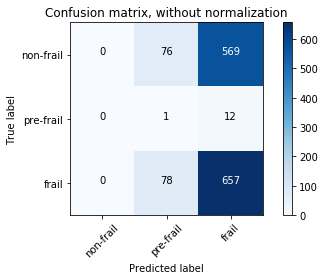

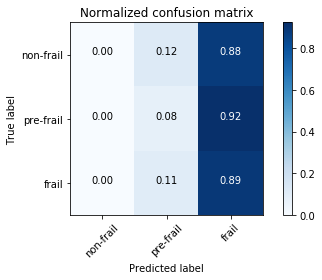

In [201]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(final_X_train, final_y_train)
preds = neigh.predict(final_X_test)
print("Accuracy score %.2f"%(accuracy_score(preds, final_y_test)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(final_y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [37]:
def one_hot(labels, n_class = 6):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = []
    for i in labels:
        y.append(expansion[int(i)])
    y = np.asarray(y)

    return y

In [42]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import keras.backend as K
#from sklearn.metrics import balanced_accuracy_score

class BalancedAccuracy(Callback):
    def __init__(self, train_data, validation_data):
        super(BalancedAccuracy, self).__init__()
        self.acas = []
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_epoch_end(self, epoch, logs={}):

        X_val = self.validation_data[0]
        y_val = self.validation_data[1]

        X_train = self.train_data[0]
        y_train = self.train_data[1]

        y_val_pred = self.model.predict(X_val)
        y_train_pred = self.model.predict(X_train)

        val_score = self.eval_avg_class_acc(y_val, y_val_pred)
        
        print("\nBalanced Accuracy - val: %.3f"%(val_score))        
        
    def eval_avg_class_acc(self, y_true, y_pred):

        # decode one-hot to single labels
        y_pred = y_pred.round()
        y_pred = [ np.argmax(pred, axis = 0) for pred in y_pred ]
        y_true = [ np.argmax(label, axis = 0) for label in y_true ]

        cf = confusion_matrix(y_true, y_pred)

        class0_acc = float(cf[0][0]) / (float(cf[0][0]) + float(cf[0][1]) + float(cf[0][2]))
        class1_acc = float(cf[1][1]) / (float(cf[1][1]) + float(cf[1][0]) + float(cf[1][2]))
        class2_acc = float(cf[2][2]) / (float(cf[2][2]) + float(cf[2][0]) + float(cf[2][1]))
        balanced_acc = float((class0_acc + class1_acc + class2_acc) / 3)

        return balanced_acc

def weighted_categorical_crossentropy(y_true, y_pred, weights):
    
    weights = K.variable(weights)
        
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

In [44]:
from functools import partial

# Weighted loss function to tackle class imbalance in the dataset

weights = np.array([float(len(final_y_train)) / float(list(final_y_train).count(0)), float(len(final_y_train)) / float(list(final_y_train).count(1)), float(len(final_y_train)) / float(list(final_y_train).count(2))])
w_cat_crossentropy = partial(weighted_categorical_crossentropy, weights = weights)
w_cat_crossentropy.__name__ = 'weighted_categorical_crossentropy'
        
balanced_accuracy = BalancedAccuracy(train_data = (final_X_train, final_y_train), validation_data = (final_X_test, final_y_test))
CALLBACKS = [balanced_accuracy]

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM
from keras.layers import Activation, BatchNormalization, Reshape
from keras.layers import Dropout
import tensorflow as tf 

model = Sequential()
model.add(Dense(128, kernel_initializer="random_uniform", input_shape = (96,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation(tf.nn.softmax))

adam = Adam(lr = 0.01)
y_train_one_hot = one_hot(final_y_train, 3)
y_test_one_hot = one_hot(final_y_test, 3)

model.compile(loss=w_cat_crossentropy, optimizer=adam, metrics=['accuracy'])

history = model.fit(final_X_train, y_train_one_hot, epochs=100, batch_size=512, validation_data=(final_X_test, y_test_one_hot), 
          verbose=2, shuffle=True, callbacks=CALLBACKS)

Train on 16556 samples, validate on 1726 samples
Epoch 1/100
 - 3s - loss: 2.7708 - acc: 0.5445 - val_loss: 7.9268 - val_acc: 0.4681

Balanced Accuracy - val: 0.474
Epoch 2/100
 - 0s - loss: 2.1702 - acc: 0.6615 - val_loss: 5.8273 - val_acc: 0.5174

Balanced Accuracy - val: 0.471
Epoch 3/100
 - 0s - loss: 1.9770 - acc: 0.6963 - val_loss: 7.4905 - val_acc: 0.4282

Balanced Accuracy - val: 0.520
Epoch 4/100
 - 0s - loss: 1.8312 - acc: 0.7185 - val_loss: 11.3605 - val_acc: 0.3053

Balanced Accuracy - val: 0.473
Epoch 5/100
 - 0s - loss: 1.7212 - acc: 0.7342 - val_loss: 6.7282 - val_acc: 0.5632

Balanced Accuracy - val: 0.531
Epoch 6/100
 - 0s - loss: 1.6013 - acc: 0.7515 - val_loss: 9.2223 - val_acc: 0.4519

Balanced Accuracy - val: 0.536
Epoch 7/100
 - 0s - loss: 1.4846 - acc: 0.7711 - val_loss: 9.6949 - val_acc: 0.5098

Balanced Accuracy - val: 0.534
Epoch 8/100
 - 0s - loss: 1.4414 - acc: 0.7798 - val_loss: 8.9986 - val_acc: 0.4467

Balanced Accuracy - val: 0.511
Epoch 9/100
 - 0s - lo


Balanced Accuracy - val: 0.601
Epoch 71/100
 - 0s - loss: 0.3314 - acc: 0.9473 - val_loss: 19.5267 - val_acc: 0.5510

Balanced Accuracy - val: 0.579
Epoch 72/100
 - 0s - loss: 0.2938 - acc: 0.9557 - val_loss: 28.4024 - val_acc: 0.4438

Balanced Accuracy - val: 0.539
Epoch 73/100
 - 0s - loss: 0.3003 - acc: 0.9525 - val_loss: 25.5210 - val_acc: 0.3957

Balanced Accuracy - val: 0.534
Epoch 74/100
 - 0s - loss: 0.3211 - acc: 0.9484 - val_loss: 36.1934 - val_acc: 0.4073

Balanced Accuracy - val: 0.538
Epoch 75/100
 - 0s - loss: 0.2812 - acc: 0.9565 - val_loss: 28.7822 - val_acc: 0.4513

Balanced Accuracy - val: 0.542
Epoch 76/100
 - 0s - loss: 0.2719 - acc: 0.9569 - val_loss: 27.1202 - val_acc: 0.4838

Balanced Accuracy - val: 0.547
Epoch 77/100
 - 0s - loss: 0.2491 - acc: 0.9608 - val_loss: 32.4718 - val_acc: 0.4287

Balanced Accuracy - val: 0.535
Epoch 78/100
 - 0s - loss: 0.2942 - acc: 0.9509 - val_loss: 23.4613 - val_acc: 0.5168

Balanced Accuracy - val: 0.569
Epoch 79/100
 - 0s - los

0.970101473728


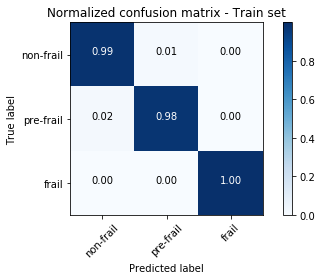

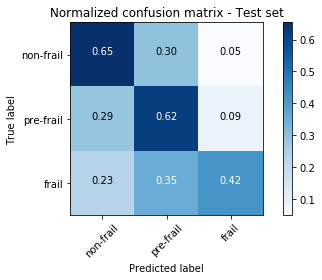

In [53]:
print(history.history["acc"][-1])

# TRAIN SET
preds = model.predict(final_X_train)

# decode one-hot to single labels
preds = [ np.argmax(pred, axis = 0) for pred in preds ]
labels = [ np.argmax(label, axis = 0) for label in y_train_one_hot ]

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                      title='Normalized confusion matrix - Train set - 3 Autoencoders')

# TEST SET
preds = model.predict(final_X_test)

# decode one-hot to single labels
preds = [ np.argmax(pred, axis = 0) for pred in preds ]
labels = [ np.argmax(label, axis = 0) for label in y_test_one_hot ]

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, preds)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                      title='Normalized confusion matrix - Test set - 3 Autoencoders')

plt.show()